In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

## Questão 1

### Considere o conjunto de dados disponível em concrete.csv, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída. Os 8 atributos referem-se à caracterização de diferentes tipos de concreto para construção civil. A saída é a resistência à compressão do concreto (em megapascals, MPa). Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/d/4353

In [14]:
dataset = np.genfromtxt('./concrete.csv', delimiter=',', skip_header=0)

#### a) Considere um modelo de regressão não linear baseado em redes neurais articiais. Separe os dados aleatoriamente em treino, validação e teste(por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:  

In [59]:
x_train, x_test_tmp, y_train, y_test_tmp = train_test_split(dataset[:,:-1],dataset[:,-1],train_size=0.6)
x_val, x_test,y_val, y_test = train_test_split(x_test_tmp,y_test_tmp, train_size=0.5)

#### MLP (multilayer perceptron): 1 camada oculta e treinamento em minibatch via gradiente descendente estocástico com termo de momentum. Utilize o conjunto de validação para ajustar os hiperparâmetros. 

In [69]:
#inicias hiper parametros
minibatch = 20
momentum = 0.9
alpha = 0.01
hidden_nodes = 10
epoches = 200
#weigh_decay = 0

In [70]:
#normalizar dados
nomalizador_x = StandardScaler().fit(x_train)
x_train = nomalizador_x.transform(x_train)
x_val = nomalizador_x.transform(x_val)

nomalizador_y = StandardScaler().fit(y_train.reshape(-1,1))
y_train = nomalizador_y.transform(y_train.reshape(-1,1))
y_val = nomalizador_y.transform(y_val.reshape(-1,1))




In [79]:
x_ = np.c_[np.ones(x_train.shape[0]),x_train]
W = np.zeros((hidden_nodes+1,x_train.shape[1]+1))
K = 1
j_history = []
m = np.zeros((hidden_nodes+1))
m[0] = np.mean(y_train)

for epoch in range(epoches):
    '''z_ = []
    for nh in range(hidden_nodes):
        zs = []      
        for i in range(x_.shape[0]):
            u = W[nh].T@x_[i]
            z = np.tanh(u)            
            zs.append(z)
        z_.append(zs)
    '''  
    z_ = []
    u_ = []  
    for nh in range(hidden_nodes+1):
        if nh == 0:
            u = W[nh]@x_
            z = np.vstack(np.ones((1, u.shape[1])),np.tanh(u))
        elif h < hidden_nodes:
            u = W[nh] @ z_[nh-1]
            z = np.vstack(np.ones((1, u.shape[1])),np.tanh(u))
        else:
            u = W[nh] @ z_[nh-1]
            z = np.tanh(u)
        u_.append(u)
        z_.append(z)

    z_ = np.array(z_)
    #z_ = np.concatenate((np.ones(x_.shape[0]).reshape(1,-1),z_),axis=0)
    
    
    o = m.T@z_ 

    #Calcula o erro
    e = (y_train-o.reshape(-1,1))    
    j = np.sum((y_train- o.reshape(-1,1))**2)/(2*x_train.shape[0])    
    j_history.append(j)

    #atualiza os parametros    
    m += (alpha * e[:,0].T)@ z_.T    
    ç = ((1-z_**2).T * m).T *e[:,0]
    #print(ç[].shape, x_.shape, alpha)
    W += ((ç@x_)*alpha)
    
    
#minibatch
#momentum
#prev
#validacao
#test


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 618 is different from 9)

array([2.08166817e-17, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

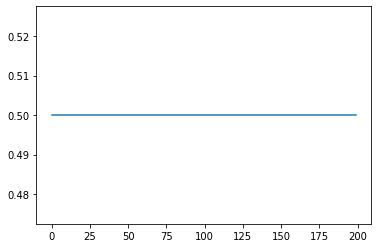

In [73]:
plt.plot(np.array(j_history))

In [74]:
o

array([7.80625564e-18, 7.80625564e-18, 7.80625564e-18, 7.80625564e-18,
       7.80625564e-18, 7.80625564e-18, 7.80625564e-18, 7.80625564e-18,
       7.80625564e-18, 7.80625564e-18, 7.80625564e-18, 7.80625564e-18,
       7.80625564e-18, 7.80625564e-18, 7.80625564e-18, 7.80625564e-18,
       7.80625564e-18, 7.80625564e-18, 7.80625564e-18, 7.80625564e-18,
       7.80625564e-18, 7.80625564e-18, 7.80625564e-18, 7.80625564e-18,
       7.80625564e-18, 7.80625564e-18, 7.80625564e-18, 7.80625564e-18,
       7.80625564e-18, 7.80625564e-18, 7.80625564e-18, 7.80625564e-18,
       7.80625564e-18, 7.80625564e-18, 7.80625564e-18, 7.80625564e-18,
       7.80625564e-18, 7.80625564e-18, 7.80625564e-18, 7.80625564e-18,
       7.80625564e-18, 7.80625564e-18, 7.80625564e-18, 7.80625564e-18,
       7.80625564e-18, 7.80625564e-18, 7.80625564e-18, 7.80625564e-18,
       7.80625564e-18, 7.80625564e-18, 7.80625564e-18, 7.80625564e-18,
       7.80625564e-18, 7.80625564e-18, 7.80625564e-18, 7.80625564e-18,
      

In [75]:
def mse_loss(y, pred):
    return np.mean((y - pred)**2)

def logistic_loss(y, pred):
    return np.mean(-y * np.log(pred) - (1-y)* np.log(1-pred))

def softmas_loss(y, pred):
    return - np.sum(y*np.log(pred))/y.shape[1]

In [76]:
def percRosen(x, y, alpha=1):
    w = np.zeros((x.shape[1]+1))
    x_ = np.c_[np.ones(x.shape[0]),x]
    y_out = []
    for xi, yi in x_, y:
        y_ = np.sign(w.T@xi)
        ei = yi - y_
        w += (alpha * ei) * xi         
        y_out.append(y_)
    j = -np.sum(y*y_out)
    return w, np.array(y_out), j

def adeline(x,y, alpha=1):
    w = np.zeros(x.shape[1]+1)
    x = np.c_[np.ones(x.shape[0]),x]
    y_out = []
    for xi, yi in x, y:
       y_ = w.T@xi
       ei = yi - y_       
       w += (alpha * ei) * xi
       y_out.append(np.sign(y_))
    j = np.sum((y-y_out)**2)/(2 * x.shape[0])
    return w, np.array(y_out), j

In [77]:
def percRosen(x, y, k=2, alpha=1):
    w = np.zeros((k,x.shape[1]+1))
    x_ = np.c_[np.ones(x.shape[0]),x]
    y_out = []
    for xi, yi in x_, y:
        yk = []
        for ki in range(k):
            y_ = np.sign(w[ki].T@xi)
            ei = yi - y_
            w[ki] += (alpha * ei) * xi 
            yk.append(y_)
        y_out.append(yk)
    j = np.sum(np.max([0,-(y_out*y)],axis=1))
    return w, np.array(y_out), j

def adeline(x,y, k=2, alpha=1):
    w = np.zeros(k,x.shape[1]+1)
    x = np.c_[np.ones(x.shape[0]),x]
    y_out = []
    for xi, yi in x, y:
        yk = []
        for ki in range(k):
            y_ = w[ki].T@xi
            ei = yi - y_       
            w[ki] += (alpha * ei) * xi
            yk.append(np.sign(y_))
        y_out.append(yk)
    j = np.sum(np.sum((y-y_out)**2,axis=1))/(2 * x.shape[0])
    return w, np.array(y_out), j

